<h1>1. Regresión Lineal Ordinaria (LSS)</h1>

In [3]:
import numpy as np
import pandas as pd

a) Se elimina id, date y zipcode ya que no aportan informacion relevante en cuanto al precio de las casas

In [ ]:
df = pd.read_csv("kc_house_data.csv")
df.drop(['id','date','zipcode',],axis=1,inplace=True)

b) El dataset consta de 18 columnas o atributos, las cuales presentan valores no nulos y enteros o reales, un total de 21.613 instancias de casas.
Todas las casas se encuentran localizadas en King County, esto se refleja en la media de la latitud y longitud (47.560053, -122.213896) y su baja desviasión estándar, la mayoria presenta entre 3 a 4 dormitorios y 1 a 2 baños, los demás datos presentan mayor dispersión por lo que no son muy útiles para generalizar.

In [ ]:
df.head()
df.shape
df.info()
df.describe()

c) Esta parte corresponde al preprocesamiento de los datos, y es utilizado cuando los datos tienen valores muy dispersos (en este caso casi todos exceptuando: 'bedrooms', 'bathrooms', 'lat', 'long'). La motivación detrás de esto radica en que algunos algoritmos, la función objetivo no funciona muy bien sin antes realizar normalización, es decir los datos deben comportarse parecido a una distribución normal estándar.
Luego se aplica función logaritmo al valor del precio ya que lo que nos interesa son los cambios relativos de este valor según los atributos en juego.

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled['price'] = np.log(df['price'])
df_scaled.describe()

d) Los datos ya se han centrado (paso anterior) por lo que el parametro 'fit_intercept' no se utilizará.
Luego nos interesan todas las columnas exceptuando 'price' ya que solo se quiere incluir los parámetros como los valores de $X$. La linea 4 añade la columna nº18 (luego de eliminar la columna *'price'*) de intercepto, este paso es el mismo realizado en clases en donde el intercepto de la ecuación lineal que representa el comportamiento del precio de acuerdo a los atributos es añadido al dataset o matriz de parámetros $X$ con el fin de encapsular el parámetro desconocido (*$b_0$*) en un solo vector (columna).

Como se mencionó anteriormente, *'fit_intercept'* no se utilizará ya que el intercepto es eliminado de la ecuación lineal e integrado a la matriz de parámetros por lo tanto en los argumentos de la función que implementa la regresión lineal no será necesario. Luego *'normalize'* es ignorado ya que esto se realizo en el paso anterior y *'n_jobs'* es utilizado para dividir el trabajo en multiples CPUs.


In [ ]:
import sklearn.linear_model as lm
X = df_scaled.iloc[:,1:] #use .ix instead, in older pandas version //Se consideran todas las filas y columnas menos 'price'
N = X.shape[0] #Cantidad de filas
X.insert(X.shape[1], 'intercept', np.ones(N)) #X.shape[1] = dimensionalidad de datos (18, incluyendo intercepto)
y = df_scaled['price']

#mascara estatica con el 70% de los datos
mascara = np.zeros(len(X))
limit = int(len(X)*0.7)
mascara[:limit] = 1
istrain = mascara == 1
Xtrain = X[istrain]
ytrain = y[istrain]
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]

linreg = lm.LinearRegression(fit_intercept = False)
linreg.fit(Xtrain, ytrain)
#predictions_train = linreg.predict(x_train)
#residuals_train = predictions_train - ytrain

In [ ]:
linreg.score(Xtest, ytest) #Coeficiente de determinacion R^2

e) Las variables con mayor correlación con la respuesta son *'sqft_above'*, *'sqft_basement'* y *'sqft_living'* ya que presentan el mayor peso absoluto. Luego, un atributo con $z-score$ mayor a 1.960 en valor absoluto es importante a un nivel de significancia del 5%, por lo tanto *'sqft_living'* y *'sqft_above'* serían las variables con mayor influencia, esto es causado ya que son los atributos que mas impacto tienen en el precio final de las casas, al calcular el $z-score$ con 5% de significancia tenemos que con un 95% de confiabilidad los atributos son relevantes, y esto se sostiene hasta con un nivel de significancia del 1% (|z-score| > 2.576).

In [ ]:
from scipy.stats import zscore
from scipy.stats import t
df_e = pd.DataFrame(zip(X.columns, linreg.coef_,), columns = ['Atributos', 'Pesos'])
zscore = df_e[df_e.select_dtypes(include=[np.number]).columns].apply(zscore)
df_e.insert(df_e.iloc[:,:].shape[1], "Z-scores", zscore)
df_e

In [ ]:
yhat_test = linreg.predict(Xtest)
mse_test = np.mean(np.power(yhat_test - ytest, 2))
Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
mse_cv = 0
for train, val in kf.split(Xm):
linreg = lm.LinearRegression(fit_intercept = False)
linreg.fit(Xm[train], ym[train])
yhat_val = linreg.predict(Xm[val])
mse_fold = np.mean(np.power(yhat_val - ym[val], 2))
mse_cv += mse_fold
mse_cv = mse_cv / 10

<h1>2. Selección de Atributos</h1>

Esta sección se enfoca en que "Selección de modelos" (Model Selection). En la sección anterior se pudo apreciar el peso respectivo al modelo de cada uno de los parámetros incluidos en el dataset <i>Houses Sales in King County</i>, esto obteniendo el Z-score de cada uno, lo que nos da una interpretación de la importancia del atributo en el modelo.

En particular el estimador utilizado en nuestro modelo de regresión, i.e. mínimos cuadrados, presenta un bajo bias y una alta varianza. La precisión de las predicciones pude ser mejorada eliminando ciertos parámetros del modelo, en particular se podrían establecer subconjuntos de atributos que presenten distintas precisiones entre ellos. De esta manera se trabaja con Model Selection.

Una técnica para realizar Model Selection es <b>Forward Stepwise Subset Selection</b>; la lógica de este método consiste en navegar el espacio posible de subconjuntos de parámetros, en particular se parte entrenando un modelo incorporando solo el <i>intercepto</i> y luego en cada iteración se repite el paso agregando el parámetro, cuyo ingreso represente un mejor ajuste del modelo, esto utilizando alguna métrica:
<ul>
<li>Error residual de mínimos cuadrados</li>
<li>Z-score</li>
<li>F-statistics</li>
</ul>

Al escoger un subconjunto de parámetros se genera un modelo que es interpretable y probablemente tiene un menor error de predicción que el modelo original. El problema recae en que al ser un proceso discreto, la eliminación o agregación de parámetros en general exibe gran varianza.

In [9]:
import matplotlib.pyplot as plt
def fss(x, y, names_x, k = 10000):
    p = x.shape[1]-1
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = range(0, p)
    selected = [p]
    xplot = []
    yplot = []
    current_score = best_new_score = 0.0
    while remaining and len(selected)<=k :
        score_candidates = []
        for candidate in remaining:
            model = lm.LinearRegression(fit_intercept=False)
            indexes = selected + [candidate]
            x_train = x[:,indexes]
            predictions_train = model.fit(x_train, y).predict(x_train)
            residuals_train = predictions_train - y
            mse_candidate = np.mean(np.power(residuals_train, 2))
            score_candidates.append((mse_candidate, candidate))
        score_candidates.sort()
        score_candidates[:] = score_candidates[::-1]
        best_new_score, best_candidate = score_candidates.pop()
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        print "selected = %s ..."%names_x[best_candidate]
        xplot.append(len(indexes))
        yplot.append(best_new_score)
        print "totalvars=%d, mse = %f"%(len(indexes),best_new_score)
    plt.plot(xplot,yplot)
    plt.show()
    return selected

selected = grade ...
totalvars=2, mse = 0.143260
selected = lat ...
totalvars=3, mse = 0.103340
selected = sqft_living ...
totalvars=4, mse = 0.084960
selected = yr_built ...
totalvars=5, mse = 0.075447
selected = view ...
totalvars=6, mse = 0.071782
selected = sqft_living15 ...
totalvars=7, mse = 0.069979
selected = bathrooms ...
totalvars=8, mse = 0.068251
selected = condition ...
totalvars=9, mse = 0.066864
selected = waterfront ...
totalvars=10, mse = 0.065836
selected = floors ...
totalvars=11, mse = 0.065107
selected = sqft_lot ...
totalvars=12, mse = 0.064820
selected = yr_renovated ...
totalvars=13, mse = 0.064619
selected = bedrooms ...
totalvars=14, mse = 0.064583
selected = sqft_above ...
totalvars=15, mse = 0.064554
selected = sqft_lot15 ...
totalvars=16, mse = 0.064527
selected = long ...
totalvars=17, mse = 0.064516
selected = sqft_basement ...
totalvars=18, mse = 0.064516


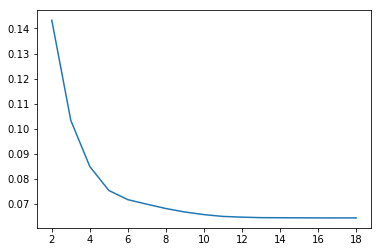

[17, 8, 13, 2, 11, 6, 15, 1, 7, 5, 4, 3, 12, 0, 9, 16, 14, 10]

In [10]:
df = pd.read_csv("kc_house_data.csv")
df.drop(['id','date','zipcode',],axis=1,inplace=True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled['price'] = np.log(df['price'])

import sklearn.linear_model as lm
X = df_scaled.iloc[:,1:]
N = X.shape[0] #Cantidad de filas
X.insert(X.shape[1], 'intercept', np.ones(N))
y = df_scaled['price']

mascara = np.zeros(len(X))
limit = int(len(X)*0.7)
mascara[:limit] = 1
istrain = mascara == 1
Xtrain = X[istrain]
ytrain = y[istrain]
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]

Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()

names_regressors = X.columns[:-1]
fss(Xm,ym,names_regressors)

<h1>3. Regularización</h1>

<h1>4. Drift</h1>

<h1>5. Detectar enfermedades cardiacas</h1>

En esta sección se debe realizar un preprocesamiento del dataset para que el modelo de Regresión Lineal se ajuste correctamente a los datos; en particular se deben crear nuevas columnas para todas las variables categóricas. Al realizar esto se asegura de que el modelo no considere estos valores como ordenados, es decir, si una variable posee 3 categorías codificads como {1,2,3}, hay que "explicarle" al modelo que tener un valor 1 no significa que sea menor que tener un valor 3, son solo valores categóricos distintos independientes entre ellos.

Por ejemplo, para la variable 'chest_pain' se crean 3 nuevas columnas en donde se codifica la presencia (con 0 y 1) de cada uno de los posibles valores en su dominio, por lo tanto queda claro que la variable 'chest_pain' posee 3 valores distintos.

Además de esto, y al igual que en la sección 1, se debe realizar una estandarización de los datos para asegurarnos de que nuestros valores reales se muevan en un espacio similar.

In [59]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

headers = ['age','sex','chest_pain','blood_p','serum','blood_s','electro','max_heart', 'angina','oldpeak','slope',\
           'vessel','thal','normal']

df = pd.read_csv("heart.dat", header=None, names=headers, sep=' ')
#df.head()

#Data standardization
df_scaled = pd.concat([df['age'],df['blood_p'],df['serum'],df['max_heart'],df['oldpeak'],df['slope'],df['vessel']],axis=1)
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns)

#Dataframes with binary coded categorical variables
df_sex_dummies = pd.get_dummies(df['sex'], prefix='sex')
df_chest_pain_dummies = pd.get_dummies(df['chest_pain'], prefix='chest_pain')
df_electro_dummies = pd.get_dummies(df['electro'], prefix='electro')
df_thal_dummies = pd.get_dummies(df['thal'], prefix='thal')
df_categorical = pd.concat([df_sex_dummies,df_chest_pain_dummies, df_electro_dummies, df['blood_s'], df['angina'],df_thal_dummies], axis=1)

#Dataframe for coding categorical output
df_predict_dummies = pd.get_dummies(df['normal'], prefix='normal')
df_predict_dummies.drop(['normal_1'],axis=1,inplace=True)
df_predict_dummies.columns.values[0] = 'normal'

#Merging both dataframes with al preprocessed data
df = pd.concat([df_scaled,df_categorical, df_predict_dummies], axis=1)
#df.head()

In [60]:
import sklearn.linear_model as lm

y = df['normal']
df.drop(['normal'],axis=1,inplace=True)

X = df.iloc[:,:]
N = X.shape[0] #Cantidad de filas
X.insert(X.shape[1], 'intercept', np.ones(N))

#mascara estatica con el 70% de los datos
mascara = np.zeros(len(X))
limit = int(len(X)*0.7)
mascara[:limit] = 1
istrain = mascara == 1
Xtrain = X[istrain]
ytrain = y[istrain]
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]

linreg = lm.LinearRegression(fit_intercept = False)
linreg.fit(Xtrain, ytrain)

y_hat = linreg.predict(Xtest)
y_hat_categorical = []
for val in y_hat:
    if val > 0.5:
        y_hat_categorical.append(1)
    else:
        y_hat_categorical.append(0)

#mse_matriz = np.power(y_outlier - y_predict_outlier, 2)
#mse_matriz = pd.DataFrame(mse_matriz)
#mse_matriz.describe()

ytest = ytest.tolist()

from sklearn.metrics import accuracy_score
print("Score: "+str(accuracy_score(ytest,y_hat_categorical)))

Score: 0.913580246914
